# Статистические модели прогнозирования. Практика

Анализ данных по ВВП Ганы

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
    
    Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно. 

    > Пример: ```train_df.spx.rolling(window=2).mean()```

    Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. 

    > Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

    Параметры p и q выберите по коррелограммам ACF и PACF. 

    > Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

    Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
    Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

6. Сделайте выводы по полученным результатам.

In [200]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.graphics.tsaplots as sgt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from arch import arch_model

import warnings
warnings.filterwarnings('ignore')



1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы
    о присутствии компонент тренда и сезонности в ряде.
    Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

            GDP (current US$)
year                         
1960-01-01       1.217087e+09
1961-01-01       0.000000e+00
1962-01-01       1.382353e+09
1963-01-01       1.540616e+09
1964-01-01       1.731092e+09
...                       ...
2017-01-01       6.040638e+10
2018-01-01       6.729928e+10
2019-01-01       6.833754e+10
2020-01-01       7.004320e+10
2021-01-01       7.759428e+10

[62 rows x 1 columns]


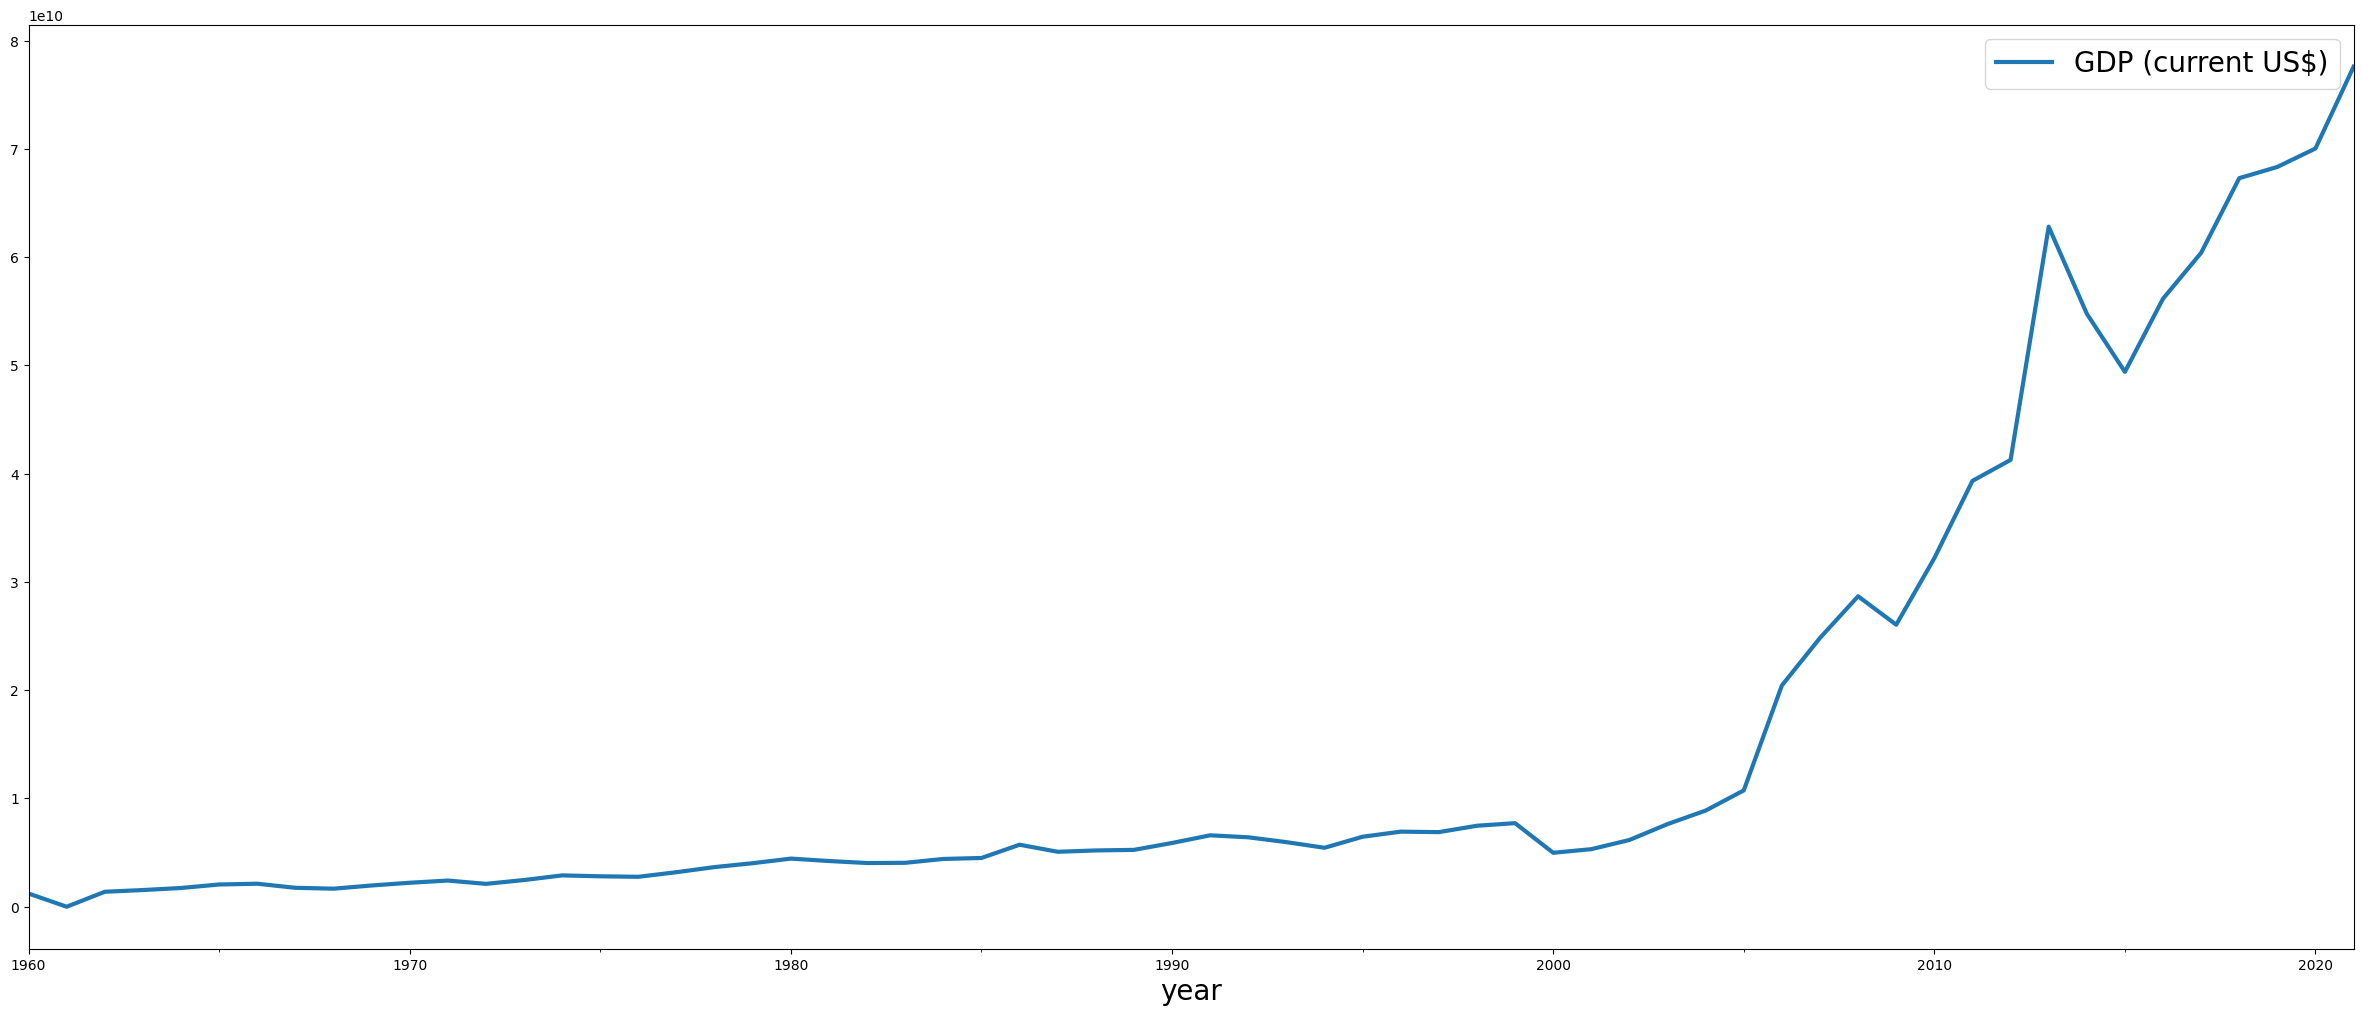

In [129]:
df = pd.read_csv('ghana_gdp.zip', parse_dates=['year'], index_col=['year'])
print(df)

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

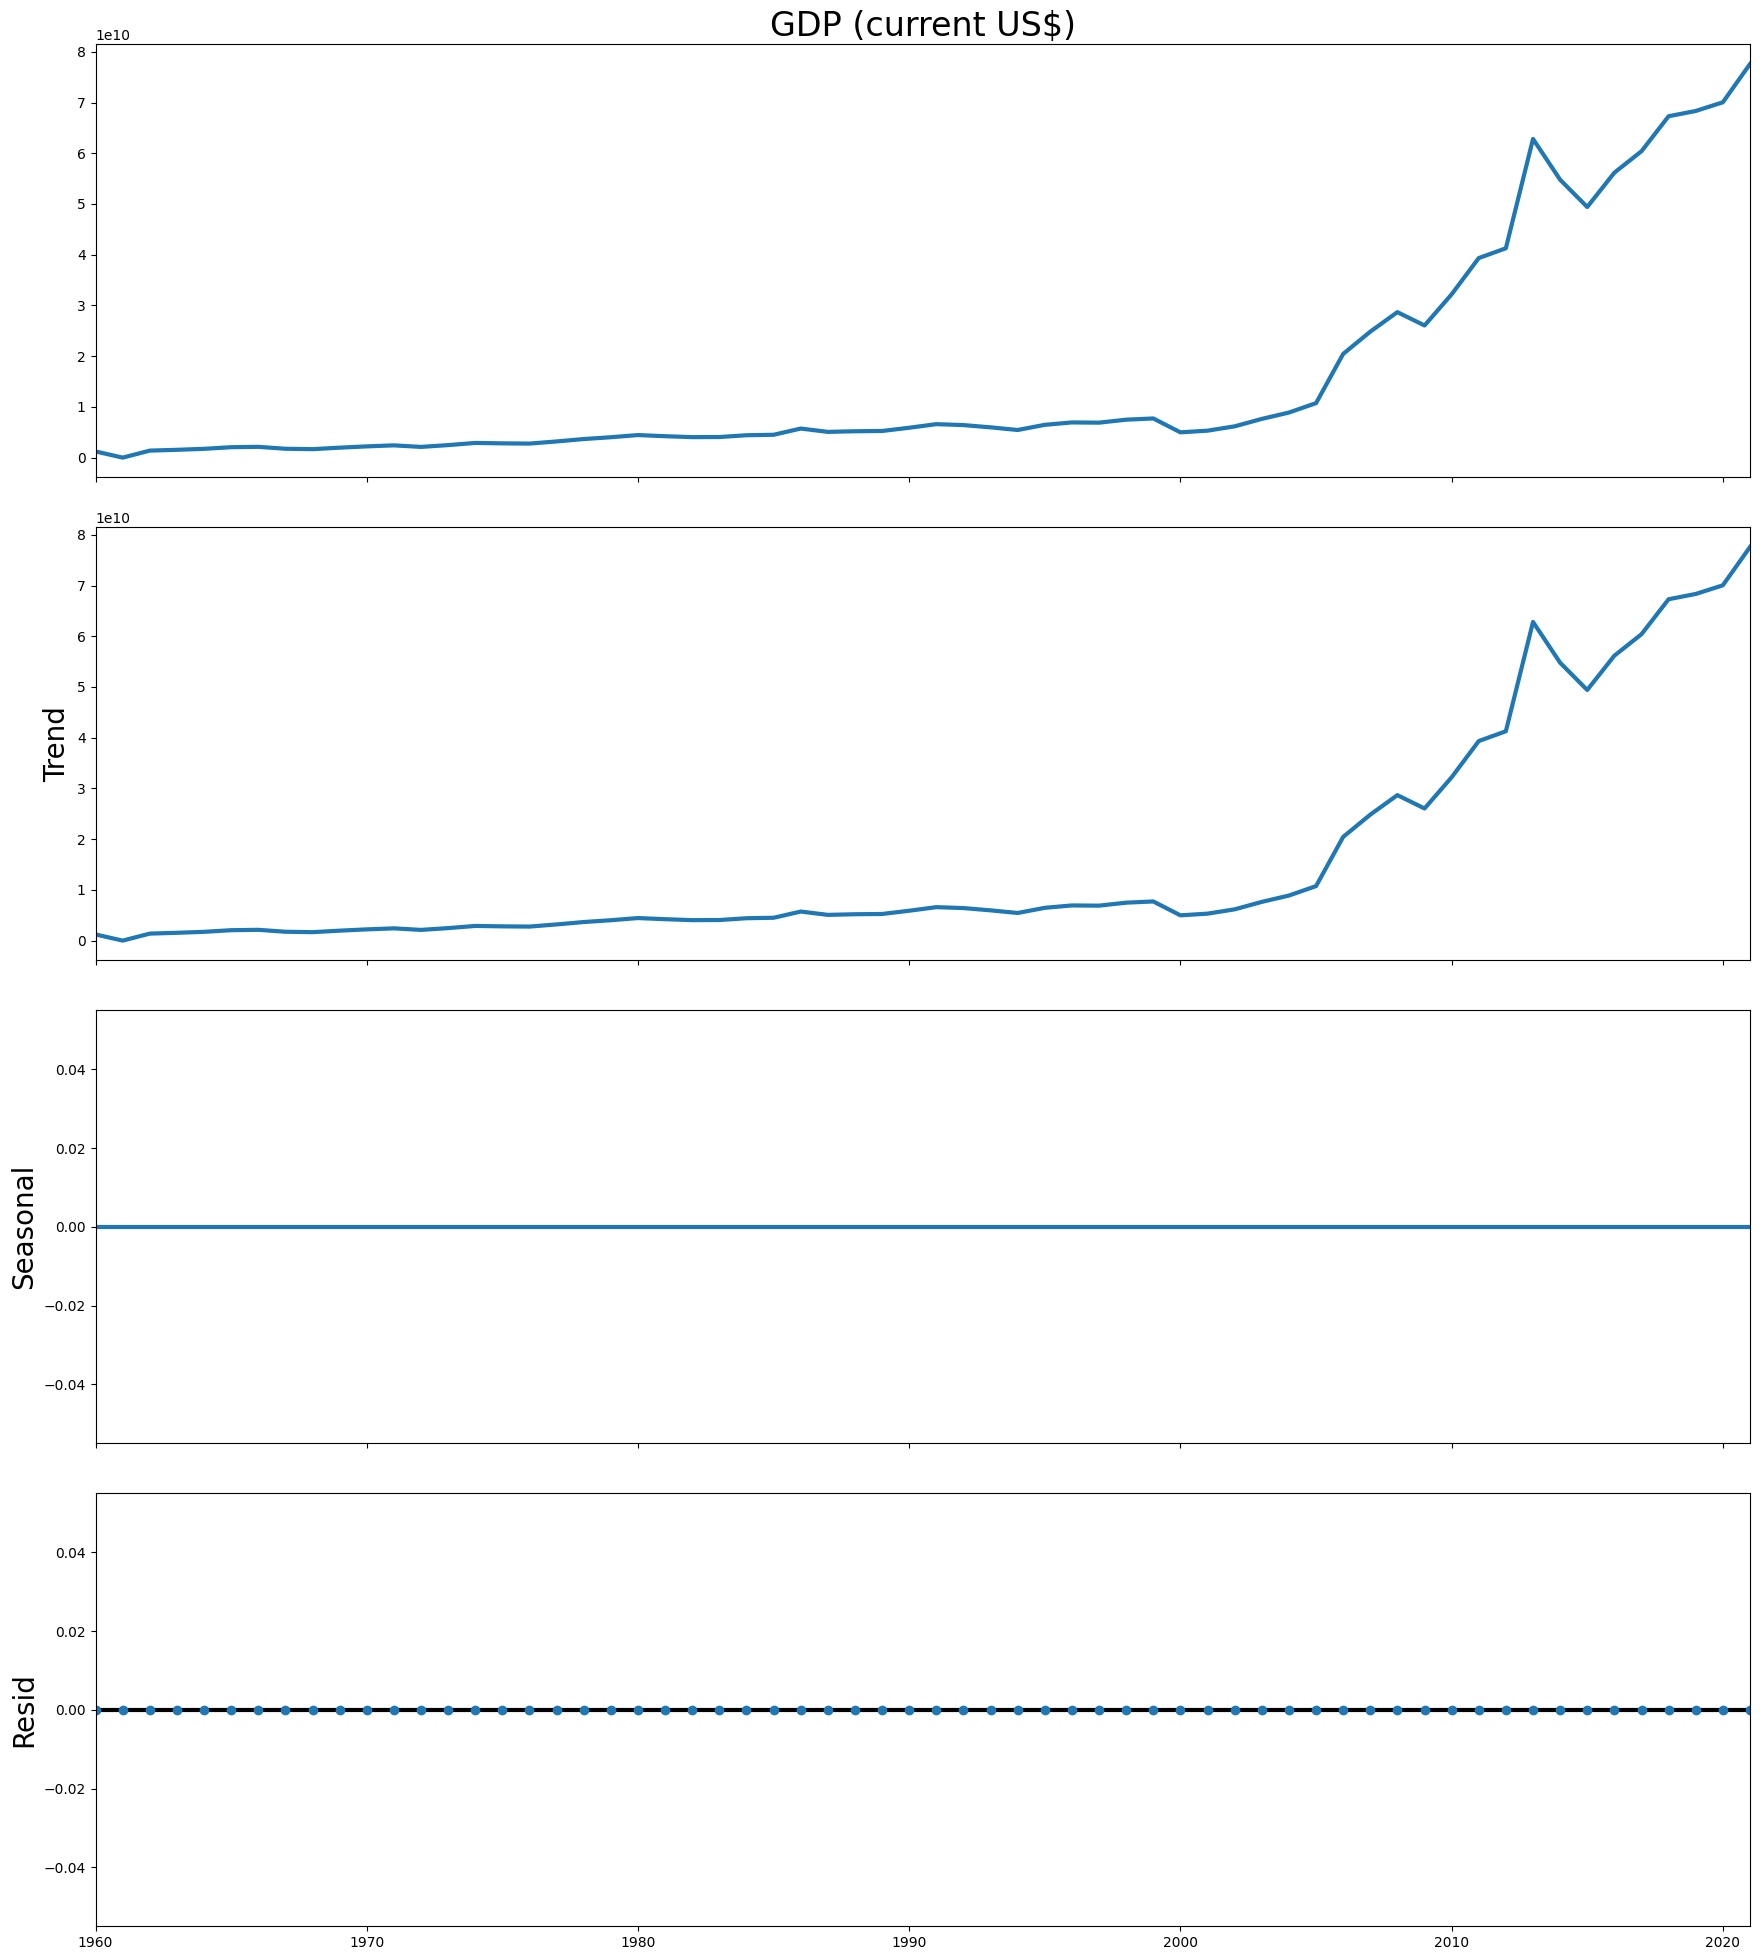

In [130]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(df['GDP (current US$)'])
result.plot()
plt.show()

#### Выводы
* виден тренд, состоящий из двух частей:
    * до 2005 года - медленно увеличивался
    * после 2005 года - быстрый рост
* сезонность отсуствует - возможно, из-за того, что данные содержать только годовые значения.
* не видно шума

In [131]:
# Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

train_df = df.loc[:"2018-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно. 

    Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

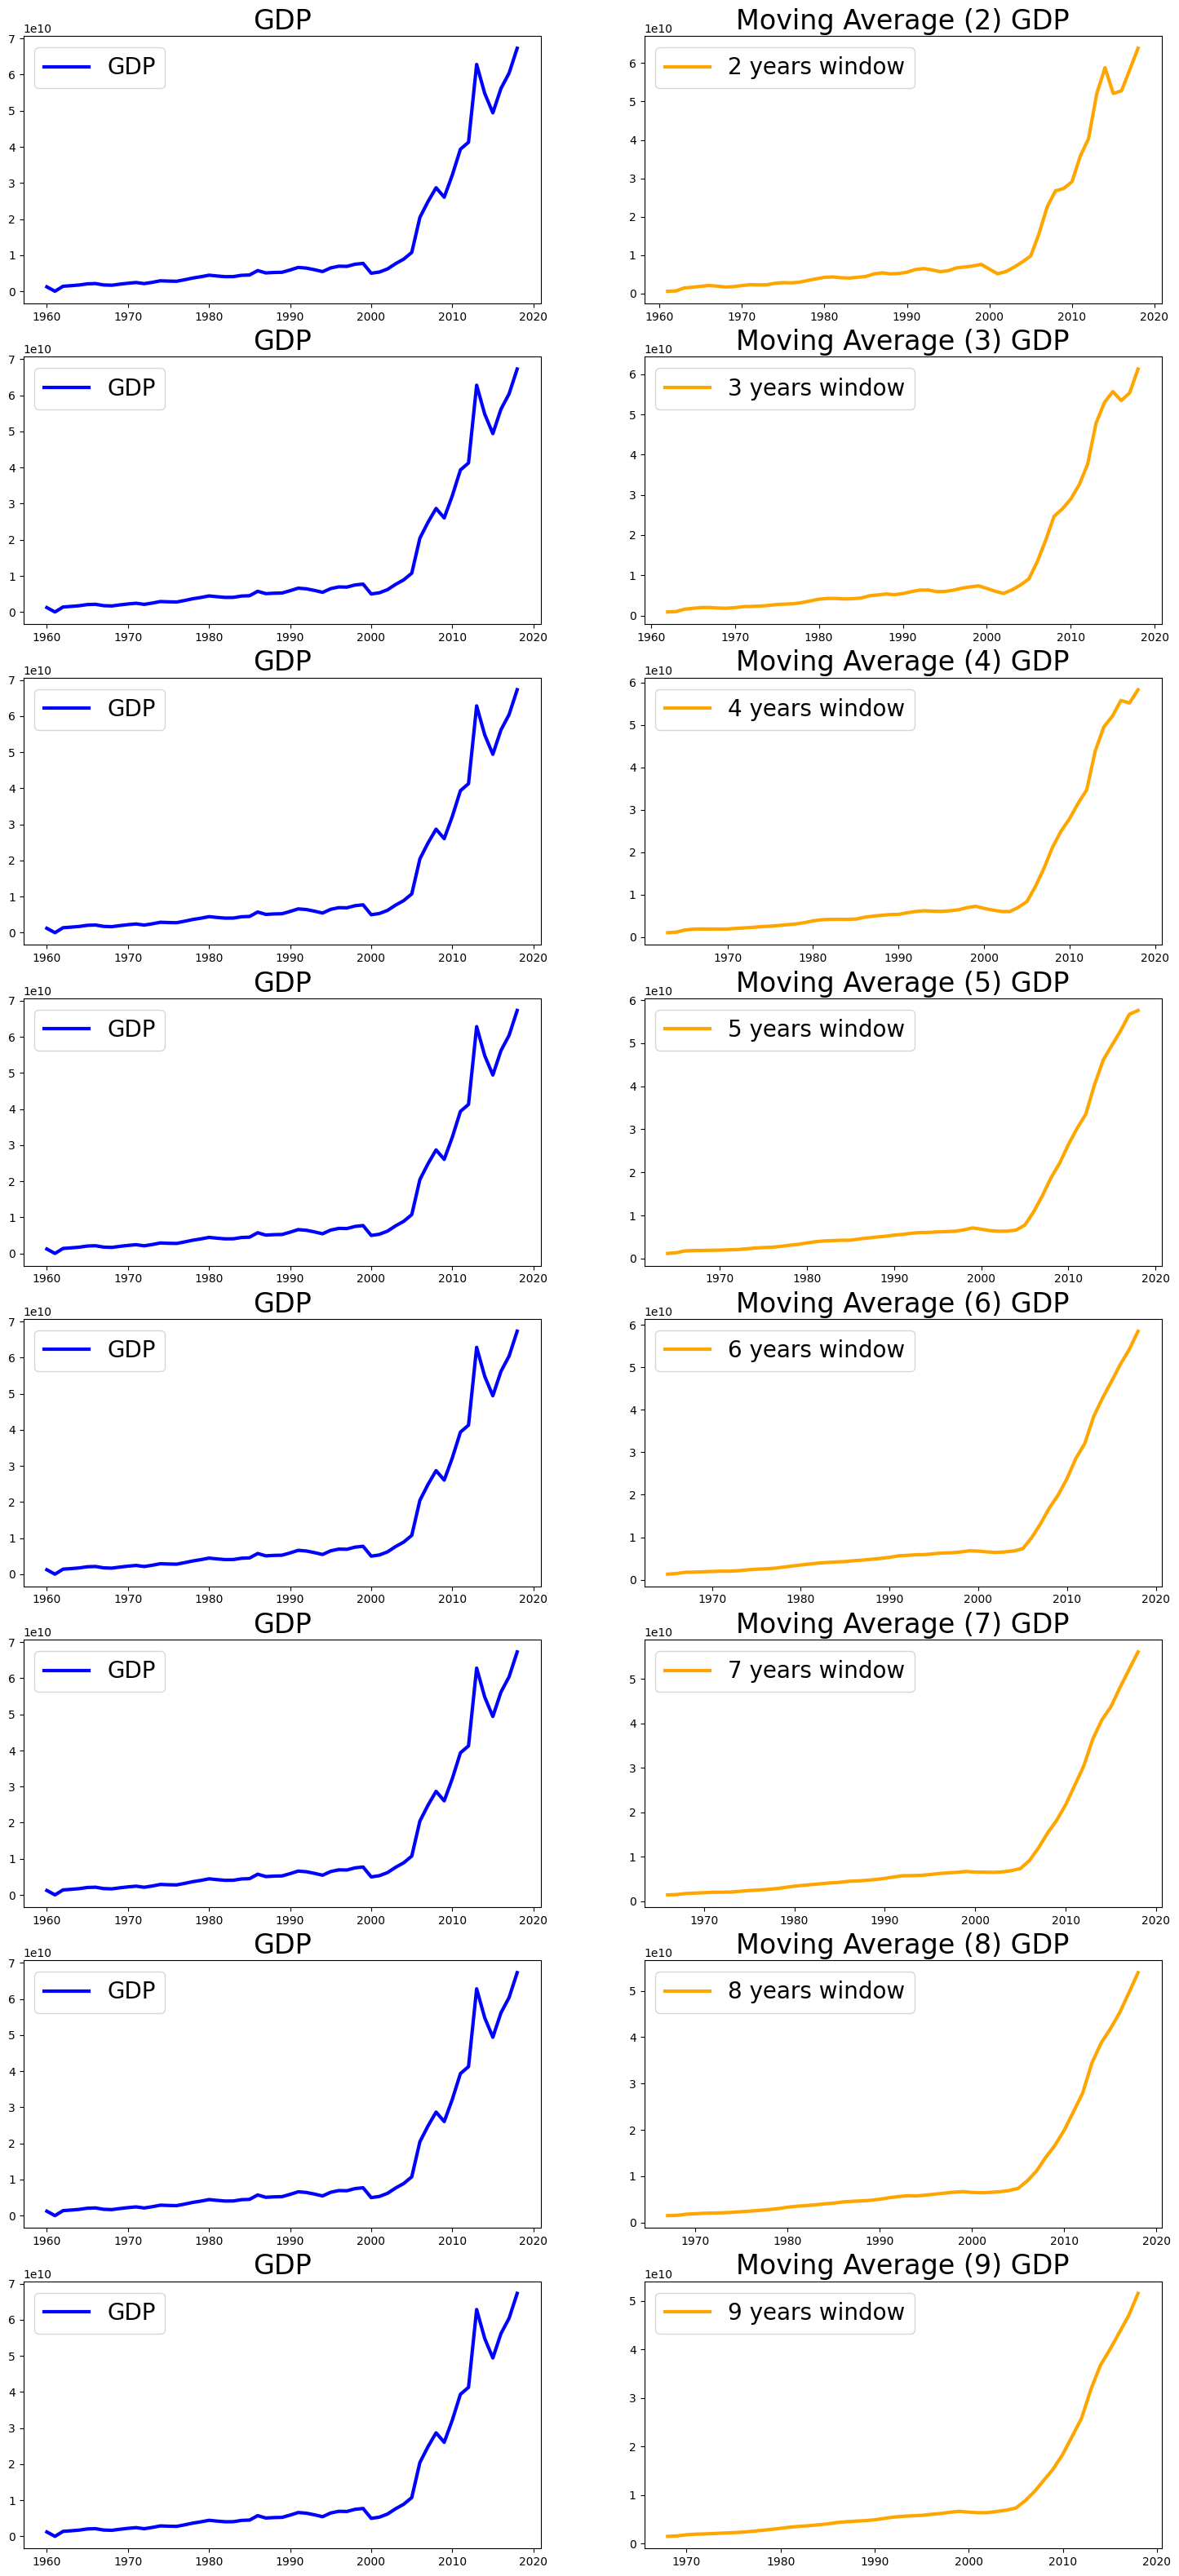

In [132]:
plt.rcParams["figure.figsize"] = 18, 40

windows_list = range(2, 10)
total_windows = len(windows_list)
fig, ax = plt.subplots(total_windows, 2)

i = 0
for window in windows_list:
    ax[i, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP")
    ax[i, 0].set_title("GDP", size=24)
    ax[i, 0].legend()

    ax[i, 1].plot(
        train_df['GDP (current US$)'].rolling(window=window).mean(),
        color="orange",
        label=f"{window} years window",
    )

    ax[i, 1].set_title(f"Moving Average ({window}) GDP", size=24)
    ax[i, 1].legend()
    i += 1
plt.show()

#### Выводы
* начиная с окна в 5 лет скользящее среднее приводит к потере информации (после 2005 года не видно колебания тренда)
* поскольку у нас нет выбросов и сезонности в данных, а также мало данных, то скользящее среднее будет показывать грубый прогноз
* для прогноза выбрал бы окно в 2 года, как наилучшее приближение к реальным данным

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. 

    > Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

    Параметры p и q выберите по коррелограммам ACF и PACF. 

    > Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

    Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.
    Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [133]:
def check_stationarity(data):
    test1 = adfuller(data)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")

check_stationarity(train_df['GDP (current US$)'])

adf:  0.6529066974885374
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [134]:
train_df_diff1 = train_df['GDP (current US$)'].diff().dropna()
print('====== Проверка на стационарность интегрированного ряда 1-го порядка =========')
check_stationarity(train_df_diff1)

train_df_diff2 = train_df['GDP (current US$)'].diff().diff().dropna()
print('\n====== Проверка на стационарность интегрированного ряда 2-го порядка =========')
check_stationarity(train_df_diff2)

train_df_diff3 = train_df['GDP (current US$)'].diff().diff().diff().dropna()
print('\n====== Проверка на стационарность интегрированного ряда 3-го порядка =========')
check_stationarity(train_df_diff3)

====== Проверка на стационарность интегрированного ряда 1-го порядка =========
adf:  -1.670248303832079
p-value:  0.4465029329713883
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен

====== Проверка на стационарность интегрированного ряда 2-го порядка =========
adf:  -2.640869056128484
p-value:  0.08484116917837775
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен

====== Проверка на стационарность интегрированного ряда 3-го порядка =========
adf:  -4.779623784828535
p-value:  5.9483276402248264e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


#### Выводы

* Поскольку изначально ряд нестационарен, нет никаких внешних факторов (не надо учитывать экзогенные переменные) и нет сезонности, то выбираем модель для прогноза - `ARIMA`, для которого выше найдет порядок дифференцирования $d = 3$

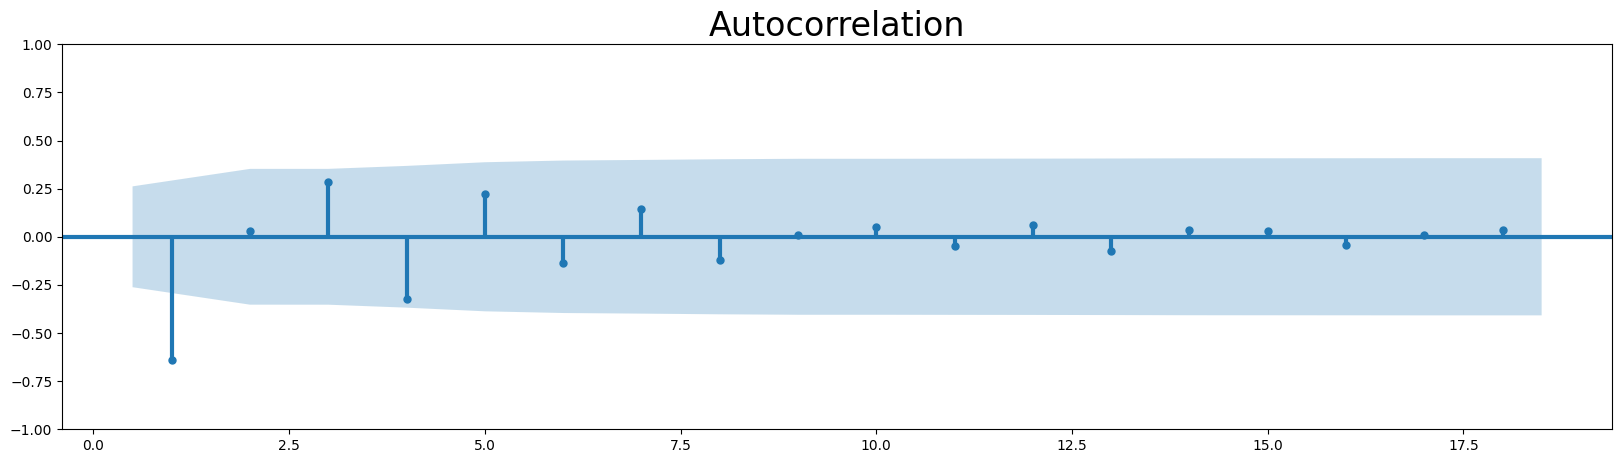

In [135]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df_diff3, zero=False)
plt.show()

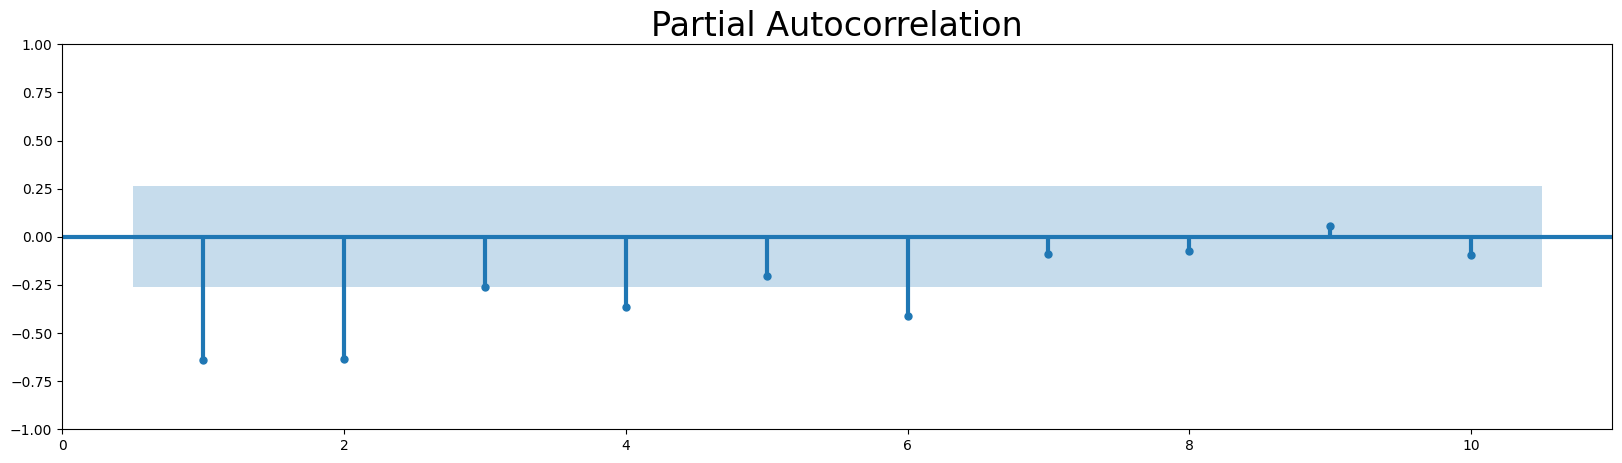

In [136]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df_diff3, lags=10, method="ywm", zero=False)
plt.show()

#### Выводы
* график автокорреляции показывает максимальное значение при лаге, равном 1, что подтверждает наличие тренда у ряда, поэтому берем $q = 1$
* последний лаг отличный от нуля на графике частичной автокорреляции равен 6, поэтому выбираем $p = 6$

In [137]:
p = 6
q = 1
d = 3
arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Sun, 18 Feb 2024   AIC                           2629.140
Time:                        11:22:34   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.943      0.000      -2.013      -1.402
ar.L3         -1.5726      0.205     -7.659      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.715      0.000      -1.924      -1.373
ar.L5         -1.2769      0.159     -8.022      0.000      -1.589      -0.965
ar.L6         -0.8853      0.148     -5.975      0.000      -1.176      -0.595
ma.L1         -0.5919      0.104     -5.673      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.70   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+54. Standard errors may be unstable.
"""

In [138]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df['GDP (current US$)'].dropna(),
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=6,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.01 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.01 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.305 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 18 Feb 2024   AIC                           2659.231
Time:                        11:22:35   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.04e+56. Standard errors may be unstable.
"""

#### Выводы
* путем проверки ряда на стационарность и анализа коррелограмм, нашли следующее:
    * модель предсказания: `ARIMA`
    * параметры модели: $d = 3$, $p = 6$, $q = 1$
    * AIC = 2629.140
* c помощью библиотеки pmdarima нашли следующие оптимальные параметры:
    * $p = 2$, $d = 3$, $q = 1$
    * AIC = 2659.231
* построим предсказания ниже для двух моделей и выберем наилучшую

### === модель ARIMA(6, 3, 1) ===

In [139]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

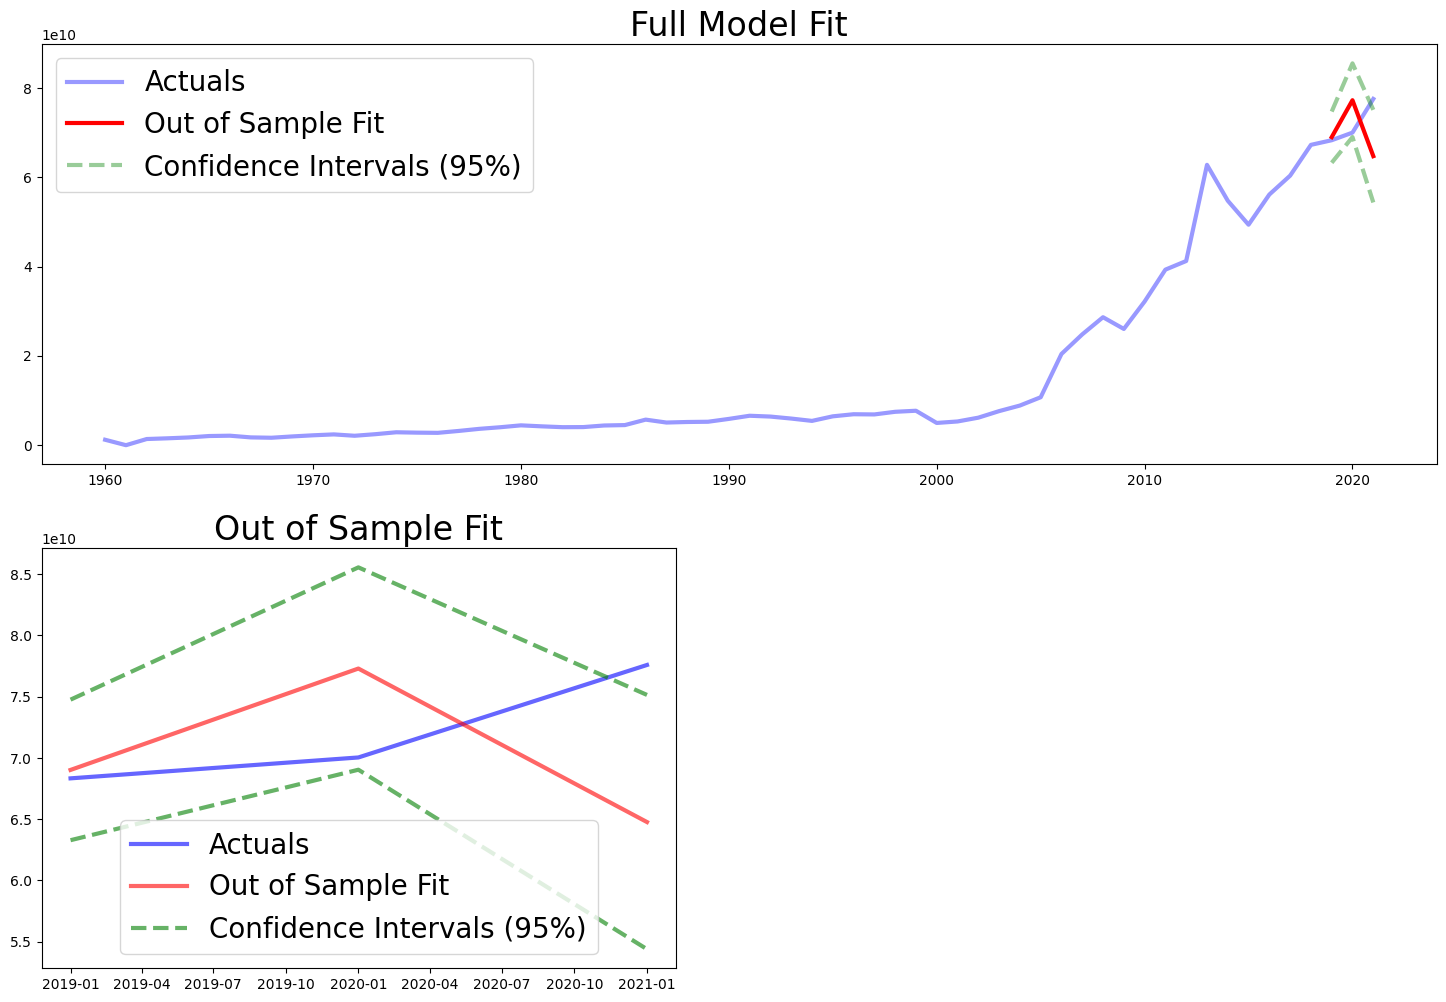

In [140]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

### === оптимальная модель ARIMA(2, 3, 1) ===

In [141]:
p = 2
q = 1
d = 3
best_arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
best_arima_model_fit = best_arima_model.fit()
best_arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sun, 18 Feb 2024   AIC                           2659.231
Time:                        11:22:35   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.04e+56. Standard errors may be unstable.
"""

In [142]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = best_arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df['GDP (current US$)']

forecast = best_arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

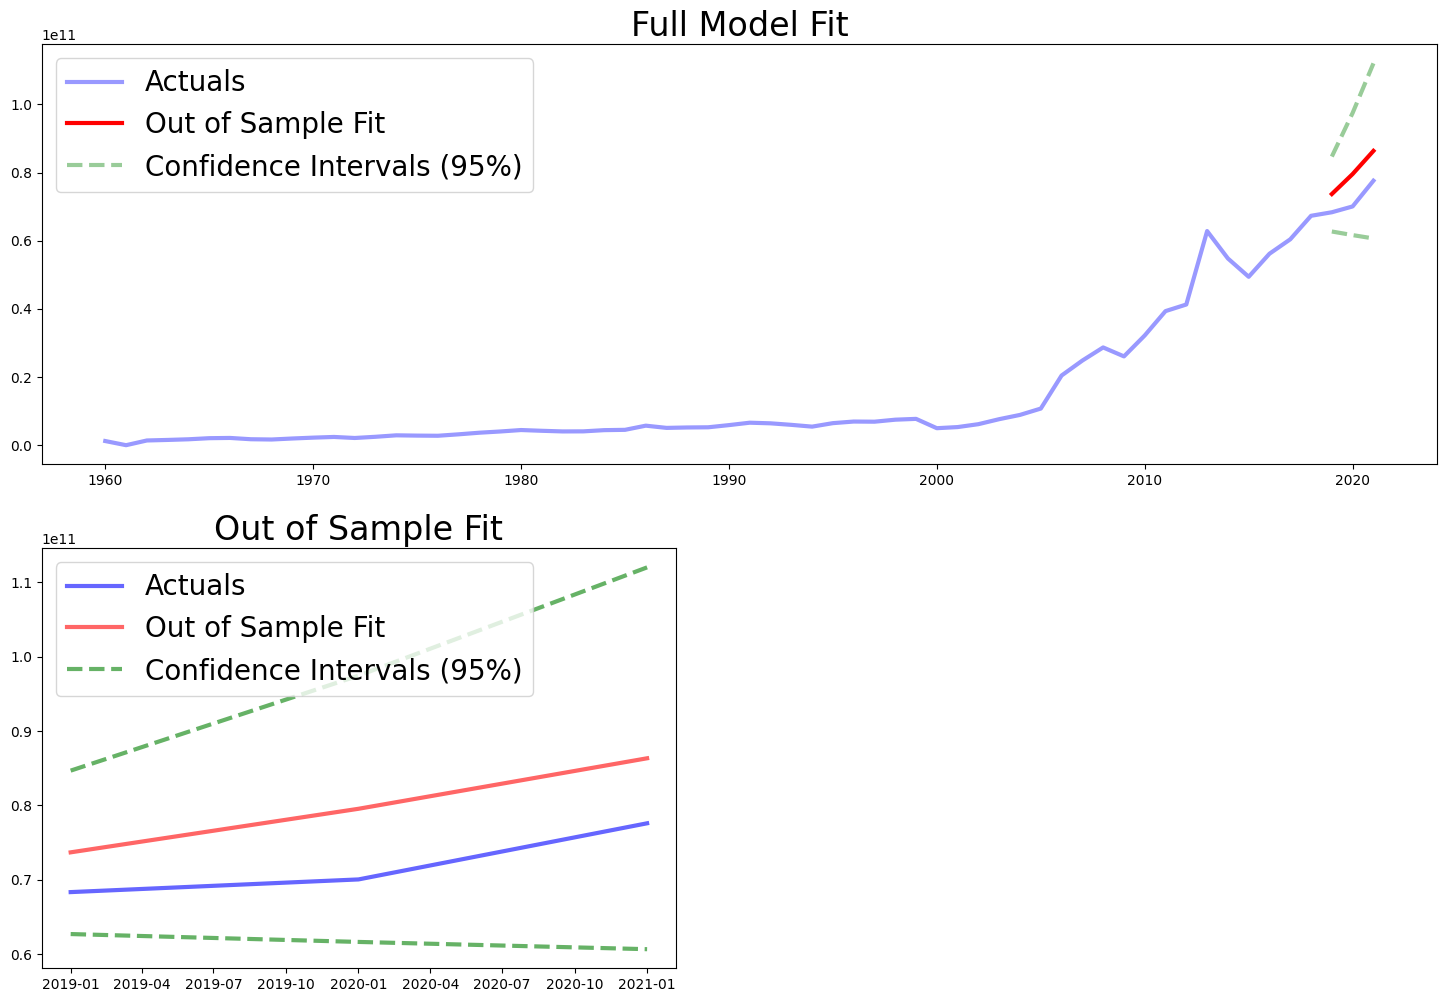

In [143]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

## Выводы
* модель ARIMA c оптимальными параметрами $p = 2$, $d = 3$, $q = 1$ показала лучшие результаты на тестовых данных, по сравнению с моделью ARIMA c параметрами подобранными из коррелограмм.

## 6. Интерполяция и сэмплирование. Практика


1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по ссылке.
        
    Подсказка
    
    df.asfreq(freq='AS')

2. Проверьте данные на наличие пропущенных значений (Series.isna().sum()).
    
3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. Воспользуйтесь кодом ниже:

    import numpy as np
    df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

4. Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

    Подсказка

    df['GDP (current US$)'].interpolate(method='linear')

5. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.
6. Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.


In [144]:
# проверем данные на наличие пропущенных дат
inter_df = df.asfreq(freq='AS')
print('Найдены пропущенные даты:', inter_df['GDP (current US$)'].isna().sum())

# заменем нулевые пропусти на NaN
inter_df['GDP (current US$)'] = inter_df['GDP (current US$)'].apply(lambda x: np.nan if x == 0 else x)
print('Найдены пропущенные даты после замены нулевых пропусков:', inter_df['GDP (current US$)'].isna().sum())

# заполним пропуски
inter_df['GDP (current US$)'] = inter_df['GDP (current US$)'].interpolate(method='linear')
print('Количество пропущенных дат после интерполяции:', inter_df['GDP (current US$)'].isna().sum())

Найдены пропущенные даты: 0
Найдены пропущенные даты после замены нулевых пропусков: 1
Количество пропущенных дат после интерполяции: 0


#### Выводы
* было пропущенно только одно значение (нулевое значение за 1961 год)

In [145]:
# Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.
train_df = inter_df.loc[:"2018-01-01"]
test_df = inter_df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

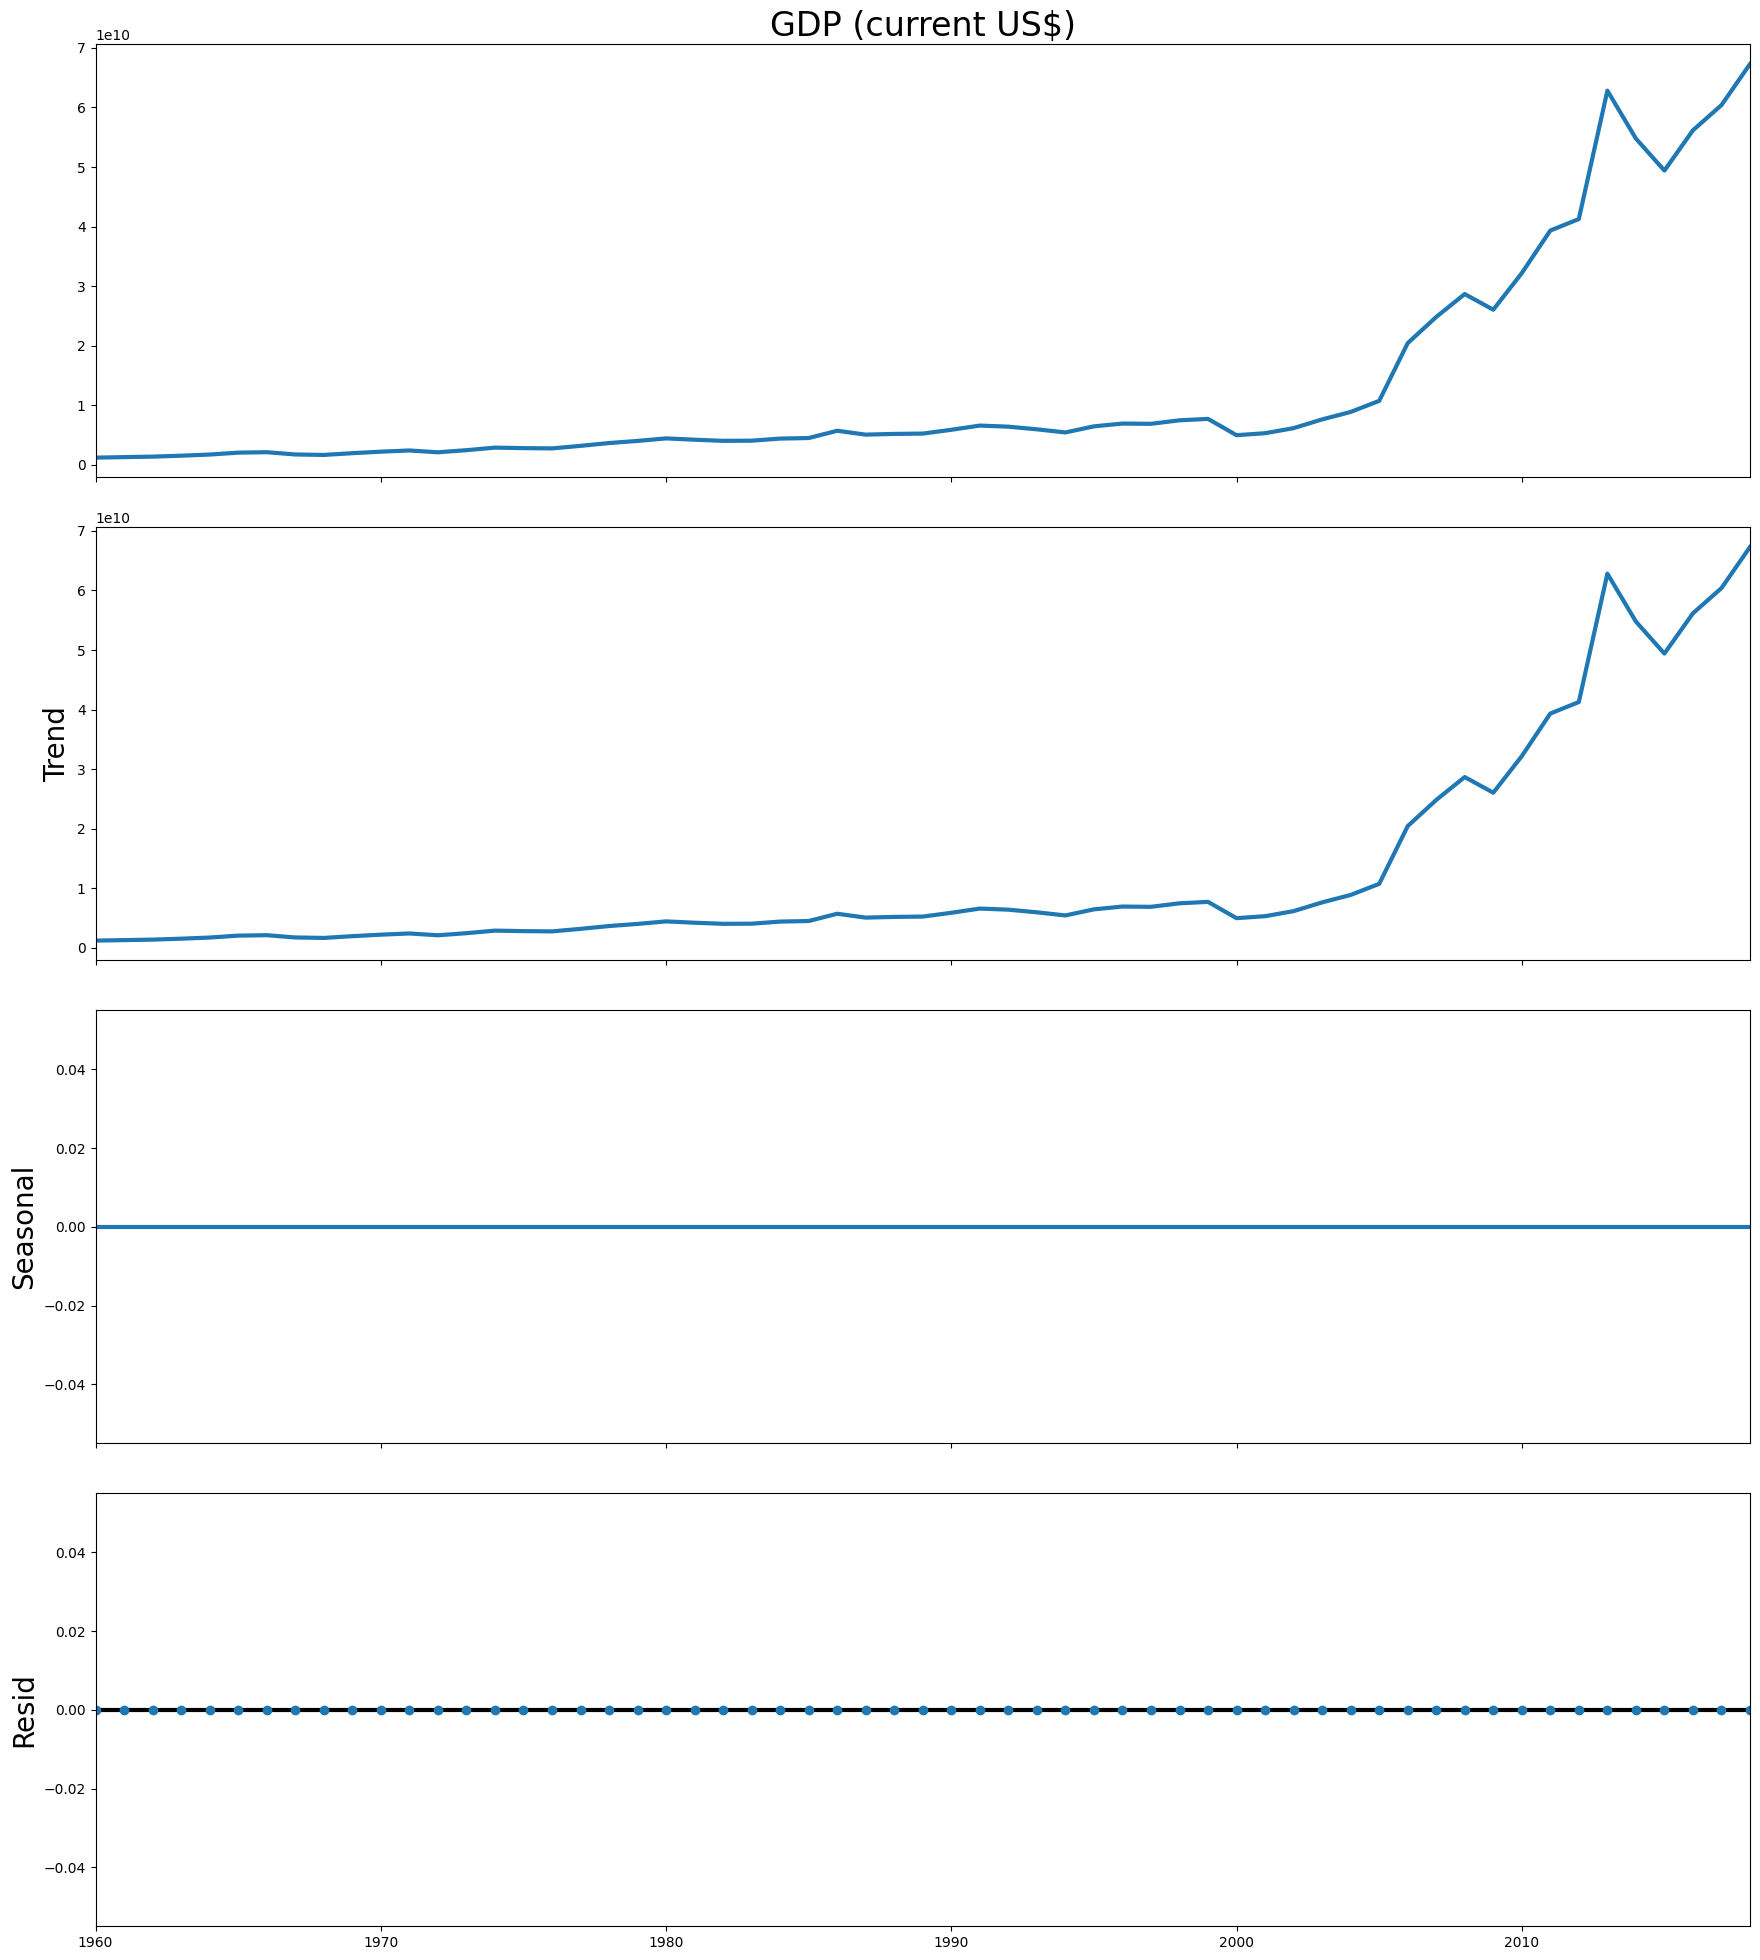

In [146]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

In [147]:
# проверим ряд на стационарность

train_df_diff1 = train_df['GDP (current US$)'].diff().dropna()
print('====== Проверка на стационарность интегрированного ряда 1-го порядка =========')
check_stationarity(train_df_diff1)

train_df_diff2 = train_df['GDP (current US$)'].diff().diff().dropna()
print('\n====== Проверка на стационарность интегрированного ряда 2-го порядка =========')
check_stationarity(train_df_diff2)

train_df_diff3 = train_df['GDP (current US$)'].diff().diff().diff().dropna()
print('\n====== Проверка на стационарность интегрированного ряда 3-го порядка =========')
check_stationarity(train_df_diff3)

====== Проверка на стационарность интегрированного ряда 1-го порядка =========
adf:  -1.8255652246436003
p-value:  0.36784515276563406
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен

====== Проверка на стационарность интегрированного ряда 2-го порядка =========
adf:  -2.6346347460078454
p-value:  0.08604813722197618
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен

====== Проверка на стационарность интегрированного ряда 3-го порядка =========
adf:  -4.825603687304035
p-value:  4.857318076799631e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


#### Выводы

* Получили такой же результат как и для ряда с пропущенным значеним, а поскольку ряд после интерполяции ряд нестационарен, нет никаких внешних факторов (не надо учитывать экзогенные переменные) и нет сезонности, то выбираем модель для прогноза - `ARIMA`, для которого выше найдет порядок дифференцирования $d = 3$

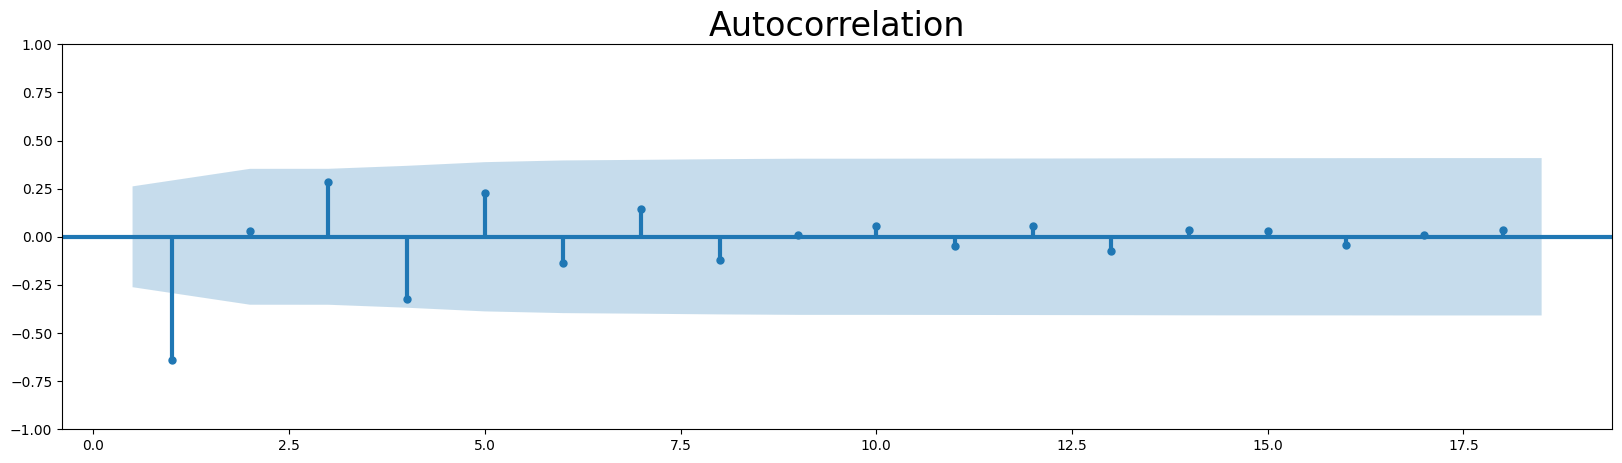

In [148]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df_diff3, zero=False)
plt.show()

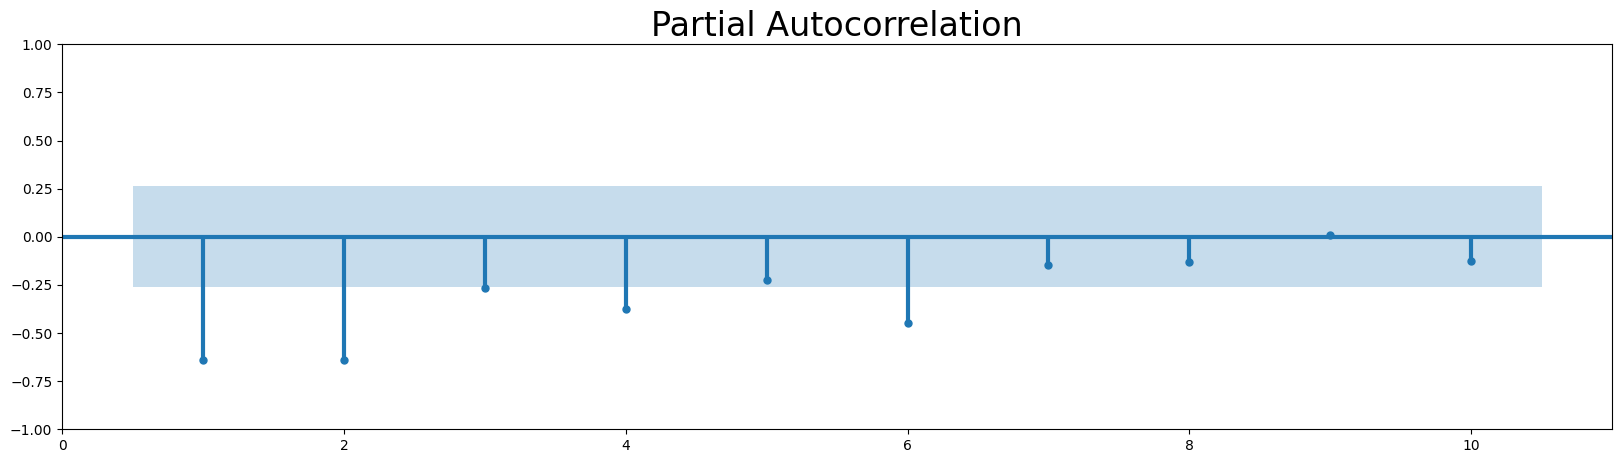

In [149]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df_diff3, lags=10, method="ywm", zero=False)
plt.show()

#### Выводы
* график автокорреляции показывает максимальное значение при лаге, равном 1, что подтверждает наличие тренда у ряда, поэтому берем $q = 1$
* последний лаг отличный от нуля на графике частичной автокорреляции равен 6, поэтому теоретически нужно  выбирать $p = 6$ как и в прошлый раз, но графики и результаты библиотеки pmdarima показали, что нужно было брать ярко выраженный лаг равным 2. Подтвердим выбор $p = 2$:

In [150]:
# найдем оптимальные параметры модели
smodel = pm.auto_arima(
    train_df['GDP (current US$)'].dropna(),
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=6,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.01 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.258 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 18 Feb 2024   AIC                           2659.226
Time:                        11:22:36   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.47e+55. Standard errors may be unstable.
"""

In [151]:
p = 2
q = 1
d = 3
best_arima_model = ARIMA(train_df['GDP (current US$)'].dropna(), order=(p, d, q))
best_arima_model_fit = best_arima_model.fit()
best_arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sun, 18 Feb 2024   AIC                           2659.226
Time:                        11:22:36   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.47e+55. Standard errors may be unstable.
"""

In [152]:
pred_df = pd.DataFrame(index=inter_df.index)

pred_df["model_preds"] = best_arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = inter_df['GDP (current US$)']

forecast = best_arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

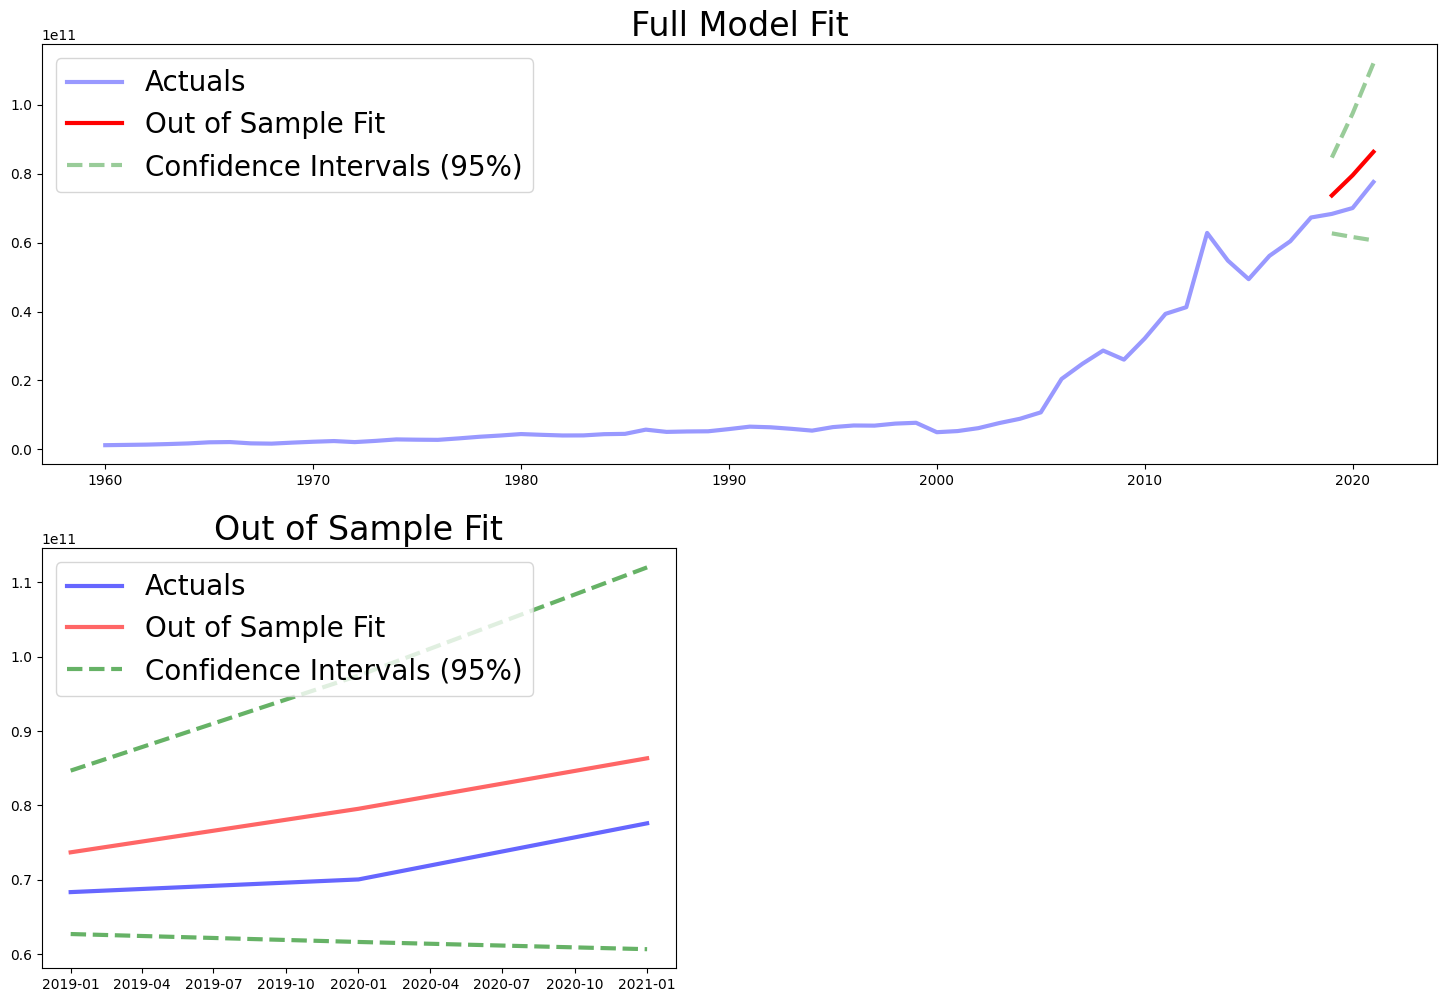

In [153]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

### Выводы
* одно пропущенное значение не повляло на характеристики ряда и, соответственно, на выбор модели предсказания и ее оптимальные параметры: все осталось таким же
* использование интерполяции не существенно улучшило значение AIC критерия:
    * AIC (для ряда с пропущенным значением) = 2659.231
    * AIC (для ряда после интерполяции) = 2659.226

#### Задание 8.3 
<img src=https://lms-cdn.skillfactory.ru/assets/courseware/v1/8016a5615b36084c9633c70a9648f8b3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md13_8_4.png>

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

    Пример кода:
    ```python
    tscv = TimeSeriesSplit(...)
    ```

2. Выведите размеры полученных подвыборок:
    ```python
    train_test_groups = tscv.split(df.sales) 
    for train_index, test_index in train_test_groups:
        print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    ```

In [156]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(df['GDP (current US$)'])

for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

* [ ] Walk forward validation
* [X] Множественное разбиение <-- поскольку размер тестовой выборки для каждого последующего разбиения увеличивается

# 9. Модели прогнозирования гетероскедастичности. Валидация временных рядов. Практика

1. Посчитайте волатильность для вашего временного ряда.
1. Используйте GARCH-модель для предсказания волатильности.
1. Используйте линейную регрессию для получения прогноза.
1. Визуализируйте полученное предсказание вместе с фактическим значением.
1. Сравните результаты и сделайте выводы.
1. Почему результат модели GARCH получился именно таким?


            GDP (current US$)    gdp_vol
year                                    
1960-01-01       1.217087e+09        NaN
1961-01-01       1.299720e+09   6.789413
1962-01-01       1.382353e+09   6.357759
1963-01-01       1.540616e+09  11.448835
1964-01-01       1.731092e+09  12.363636


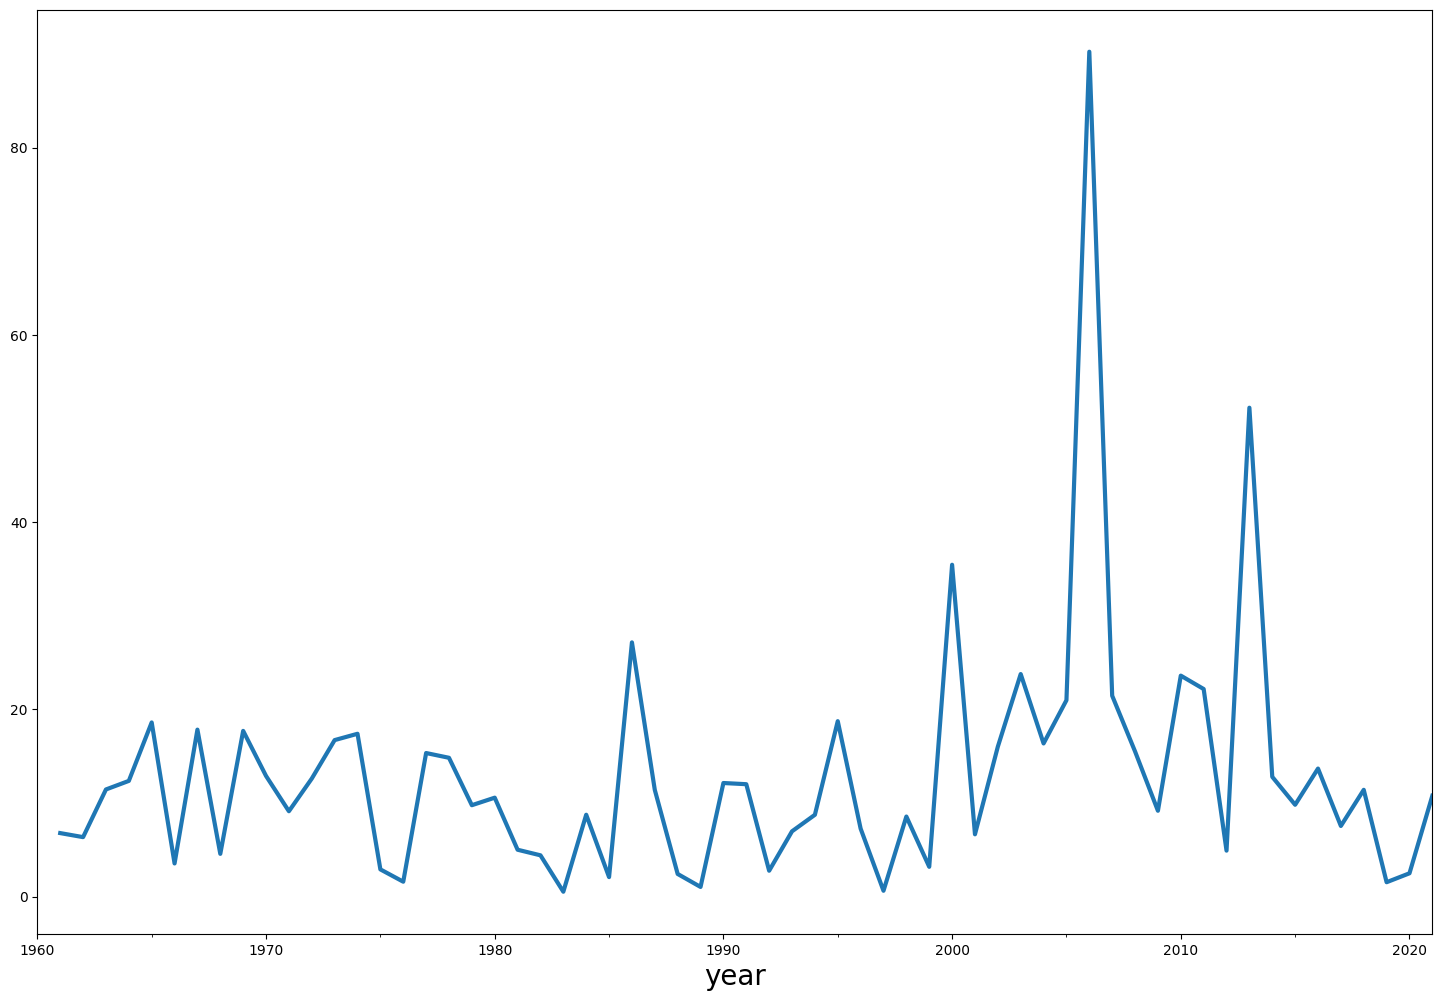

In [160]:
# используем ряд после интерполяции, чтобы не получить бесконечность в волатильности
data = inter_df.copy()

data["gdp_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
print(data.head())
data["gdp_vol"].plot()
plt.show()

In [175]:
# убираем данные за 1960-й год, польку там волатильность не определена
train_df = data.loc["1961-01-01":"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((58, 2), (3, 2))

In [176]:
# проверим ряд на стационарность
check_stationarity(train_df['gdp_vol'])


adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


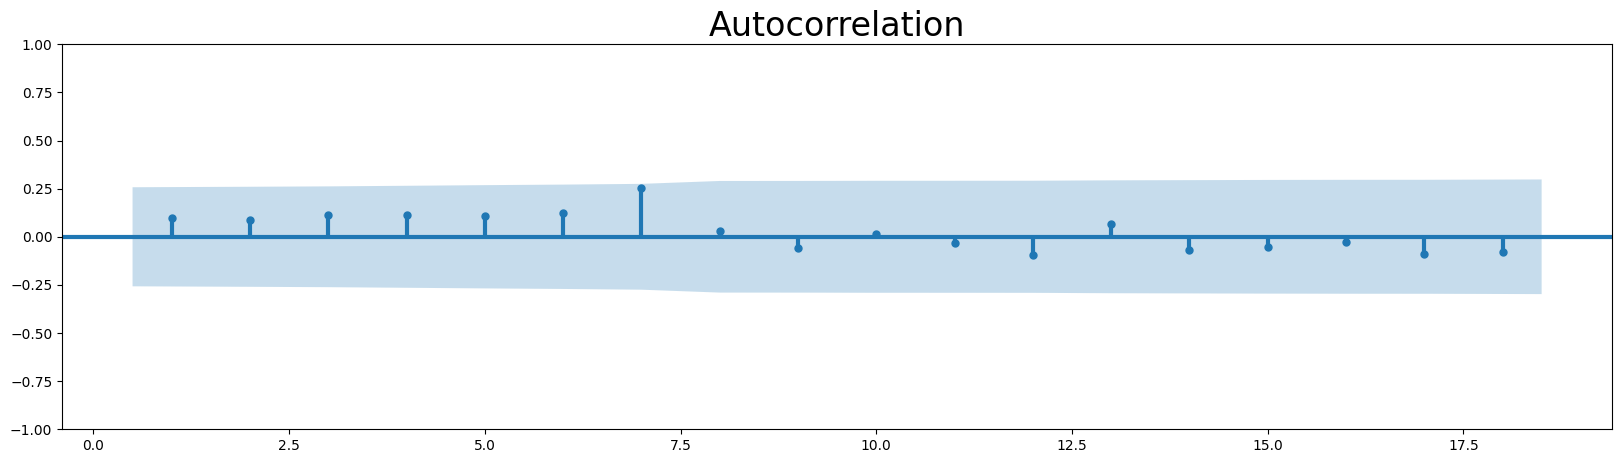

In [178]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.gdp_vol, zero=False)
plt.show()

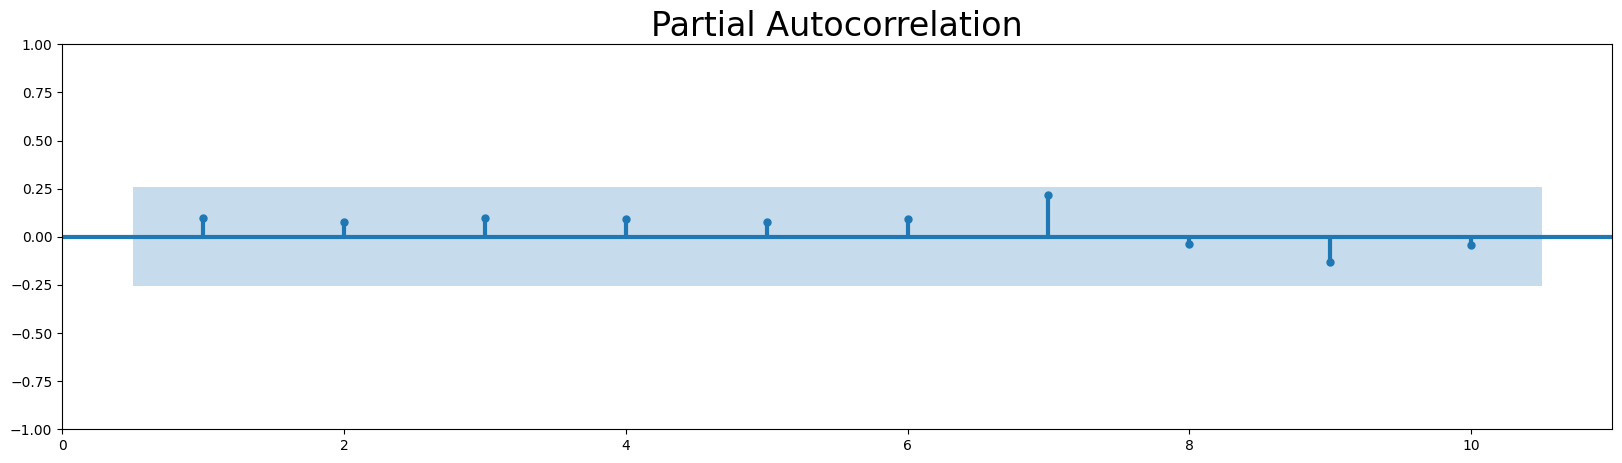

In [179]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.gdp_vol, lags=10, method="ywm", zero=False)
plt.show()

#### Выводы
* на обоих графиках видны отличающиеся значения при лаге равном 7
* применим pmdarima библиотеку для выбора оптимальных значений $p$ и $q$, поскольку значения лежать в доверительном интервали случайности.

In [180]:
# найдем оптимальные параметры модели
smodel = pm.auto_arima(
    train_df.gdp_vol,
    start_p=1,
    d=0,
    start_q=1,
    max_p=10,
    max_q=10,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=474.850, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=508.745, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=490.565, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=499.055, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=476.808, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=476.802, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=495.666, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=485.340, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=472.628, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=472.429, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=470.923, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=472.355, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.173 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:                        SARIMAX   Log Likelihood                -233.462
Date:                Sun, 18 Feb 2024   AIC                            470.923
Time:                        15:00:48   BIC                            475.044
Sample:                    01-01-1961   HQIC                           472.528
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.4593      3.155      4.265      0.000       7.275      19.644
sigma2       183.5567     20.038      9.161      0.000     144.283     222.830
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               754.91
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):              12.91   Skew:                             3.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Выводы
* библиотеке pmdarina не удалось найти оптимальные значения
* сделаем предсказания для параметров по-умолчанию (p=1, q=1) и для параметров из графиков выше (p=7, q=7)
* будем использовать MAE для оценки моделей


=============== p = 1, q = 1 ===========
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18833254549992
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4075.976317688216
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00316972567734
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.59782471363783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978123234891
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


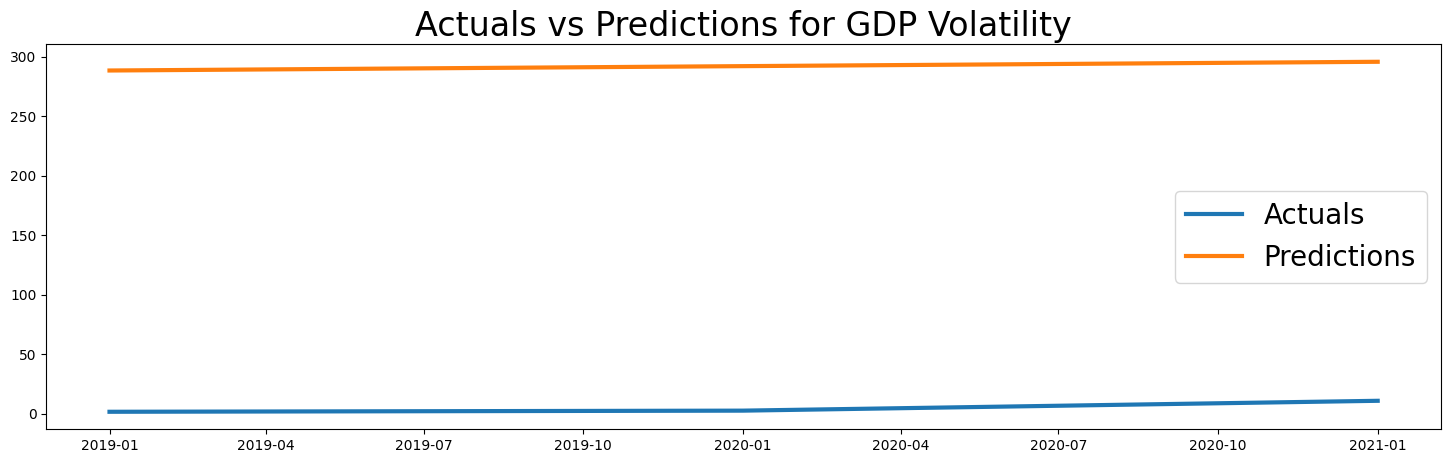

 - MAE: 82532.57469459453

=============== p = 7, q = 7 ===========
Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.38046109927802
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759092310422
Iteration:     15,   Func. Count:    265,   Neg. LLF: 214.4086949260437
Iteration:     20,   Func. Count:    350,   Neg. LLF: 214.10059731491503
Iteration:     25,   Func. Count:    435,   Neg. LLF: 214.01172373215454
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.0075073035244
            Iterations: 30
            Function evaluations: 509
            Gradient evaluations: 29


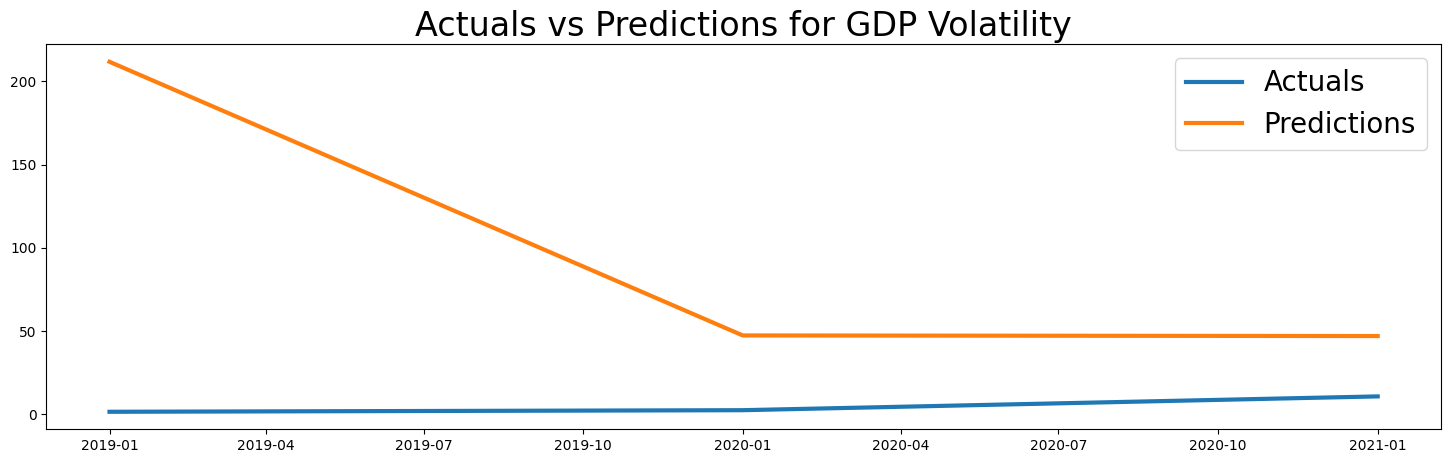

 - MAE: 15849.132286207741


In [214]:
garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index])
params_list = [
    {'p': 1, 'q': 1},
    {'p': 7, 'q': 7},
]

for params in params_list:
    p, q = params['p'], params['q']
    print(f'\n=============== p = {p}, q = {q} ===========')

    model = arch_model(garch_df["gdp_vol"].dropna(), p=p, q=q)

    # в параметре last_obs указываем последний объект, до которого будем совершать обучение.
    # в нашем случае это до первого объекта из test выборки

    model_results = model.fit(last_obs=test_df.index[0], update_freq=5)
    info = model_results.summary()

    predictions_df = test_df.copy()
    predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
        test_df.index
    ]

    plt.rcParams["figure.figsize"] = 18, 5

    plt.plot(predictions_df["gdp_vol"].abs(), label="Actuals")
    plt.plot(predictions_df["Predictions"], label="Predictions")

    plt.title("Actuals vs Predictions for GDP Volatility", size=24)
    plt.legend()
    plt.show()

    mae = mean_squared_error(
        predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
    )

    print(f' - MAE: {mae}')


In [218]:
garch_df

,gdp_vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


 - MAE: 243.78726376950712


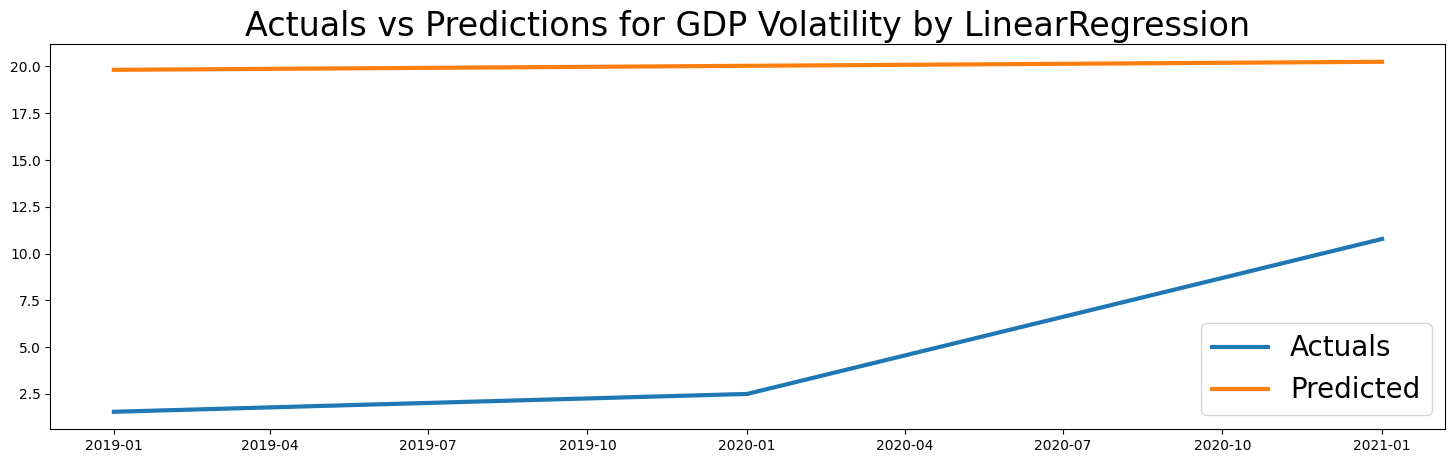

In [223]:
# Применим модель линейной регрессии для предсказания волатильности

from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gdp_vol"].shape[0] - 1))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gdp_vol"].shape[0] - 1))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

mae = mean_squared_error(y_test, lr_predict)
print(f' - MAE: {mae}')

plt.title("Actuals vs Predictions for GDP Volatility by LinearRegression", size=24)
plt.plot(y_test, label='Actuals')
plt.plot(pd.Series(lr_predict, index=y_test.index), label='Predicted')
plt.legend()
plt.show()

#### Выводы
* MAE для модели с параметрами $p=7$ и $q=7$ равна 15849, что лучше чем MAE для модели с параметрами по-умолчанию ($p = 1$, $q = 1$), которая равна 82533.
* лучшая ARCH модель все равно плохо предсказывает дисперсию. Возможно, это связано с недостаточным количеством данных
* модель линейной регрессии ближе к реальным данным, чем лучшаа ARCH модель (MAE = 244), но использовать ее вряд ли стоит, поскольку она не учитывает разброс